In [1]:
import os.path
import sys 
print("Python %s.%s.%s"%sys.version_info[:3])
import scipy.stats
import emcee
print("emcee version", emcee.__version__)
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import numpy as np

print(os.getcwd() + "\n")
#os.chdir('/Users/Isabel/Documents/Git')
#print(os.getcwd() + "\n")

Python 3.6.4
emcee version 2.2.1
/Users/Isabel/Documents/Git/GSFCS18



In [2]:
data = np.loadtxt( '/Users/Isabel/Documents/Git/fake.dat' )

Maximum likelihood estimates:
a_fitted = -0.191
b_fitted = 1.955
c_fitted = 9.653
f_average = 0.056


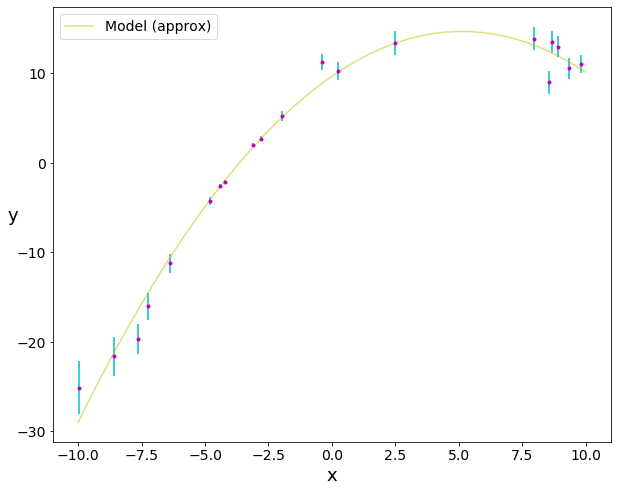

In [3]:
var1 = data[0:,0]
var2 = data[0:,1]
var3 = data[0:,2]

x = np.copy(var1)
y = np.copy(var2)
yerr = np.copy(var3)
x0 = np.linspace(-10,10, 500)

a_approx, b_approx, c_approx = np.polyfit(x,y,2)
f_approx = np.average(yerr)

print("Maximum likelihood estimates:")
print("a_fitted = {0:0.3f}".format(a_approx))
print("b_fitted = {0:0.3f}".format(b_approx))
print("c_fitted = {0:0.3f}".format(c_approx))
print("f_average = {0:0.3f}".format(f_approx))

plt.figure(figsize=(10,8))
plt.errorbar(x,y,yerr=yerr, fmt=".m", ecolor='c', capsize=0)
plt.plot(x0, a_approx*x0**2 + b_approx * x0 + c_approx, "y", alpha=0.5, label="Model (approx)")
plt.legend(fontsize=14)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

In [4]:
def log_likelihood(theta, x,y,yerr):
    a, b, c, log_f = theta
    model = a * x ** 2 + b * x + c 
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2*log_f)
    return -0.5 * np.sum((y-model) ** 2/sigma2 + np.log(sigma2))

In [5]:
from scipy.optimize import minimize
#
np.random.seed(42)
n11 = lambda *args: -log_likelihood(*args)
initial = np.array([a_approx, b_approx, c_approx, np.log(f_approx)]) + 0.1* np.random.randn(4)
soln = minimize(n11, initial, args=(x,y,yerr))
a_ml, b_ml, c_ml, log_f_ml = soln.x
#
print("Maximum likelihood estimates:")
print("a_ml = {0:0.3f}".format(a_ml))
print("b_ml = {0:0.3f}".format(b_ml))
print("c_ml = {0:0.3f}".format(c_ml))
print("f_ml = {0:0.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a_ml = -0.205
b_ml = 2.028
c_ml = 10.154
f_ml = 0.029


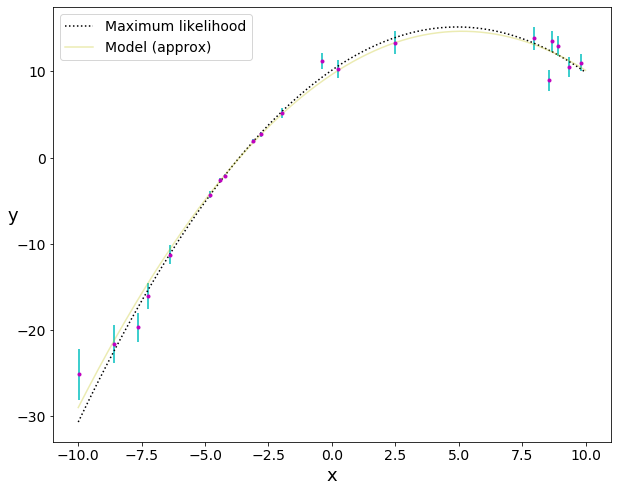

In [6]:
plt.figure(figsize=(10,8))
plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='c',capsize=0)
plt.plot(x0, a_ml*x0**2 + b_ml * x0 + c_ml, ":k", label="Maximum likelihood")
plt.plot(x0, a_approx*x0**2 + b_approx * x0 + c_approx, "y", alpha=0.3, label="Model (approx)")

plt.legend(fontsize=14)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

In [7]:
def log_prior(theta): 
    a, b, c, log_f = theta
    if -100 < a < 100 and -100 < b < 100 and -100 < c < 100 and -100 < log_f < 100: 
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [9]:
pos = soln.x + 1e-4 * np.random.randn(100, 4)
nwalkers, ndim = pos.shape

print(nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000)#, progress=True);

100


(array([[ -0.21120255,   2.06995784,  10.59091075, -89.33960073],
        [ -0.20869001,   2.07456313,  10.52072393, -43.96441942],
        [ -0.20648354,   1.9569536 ,   9.77047438, -29.34966385],
        [ -0.20710838,   2.00760645,  10.21400268, -33.8834113 ],
        [ -0.20004271,   1.98898298,  10.03404349, -17.80852818],
        [ -0.20181878,   2.02794634,  10.13246509, -13.55439158],
        [ -0.19183228,   1.98820317,   9.88851595, -78.41500615],
        [ -0.21526015,   2.06979015,  10.41870951, -41.07784806],
        [ -0.2217905 ,   2.11261609,  10.62850826, -72.65175705],
        [ -0.21156335,   1.98096618,  10.08469844, -82.21795937],
        [ -0.21056192,   2.0272014 ,  10.36376513, -95.82988683],
        [ -0.21625314,   2.05501559,  10.40382101, -68.51596847],
        [ -0.20148597,   1.92009396,   9.64163287, -42.41884812],
        [ -0.1966259 ,   2.00152449,   9.86321436, -44.5290839 ],
        [ -0.20930324,   2.10705644,  10.38719188, -67.22041135],
        [ 

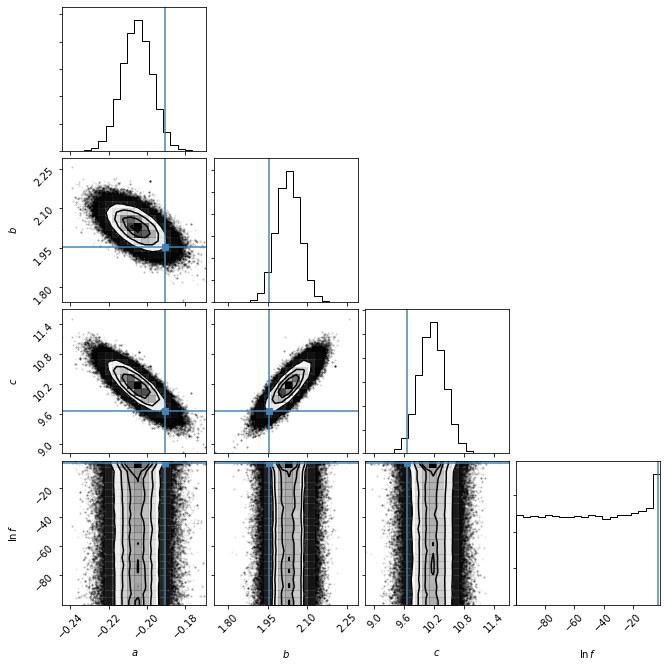

In [10]:
samples = sampler.chain[:, :, :].reshape((-1,ndim))

import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$", "$\ln\,f$"],
truths=[a_approx, b_approx, c_approx, np.log(f_approx)], figsize=(10,10))
fig.savefig("triangle.png")

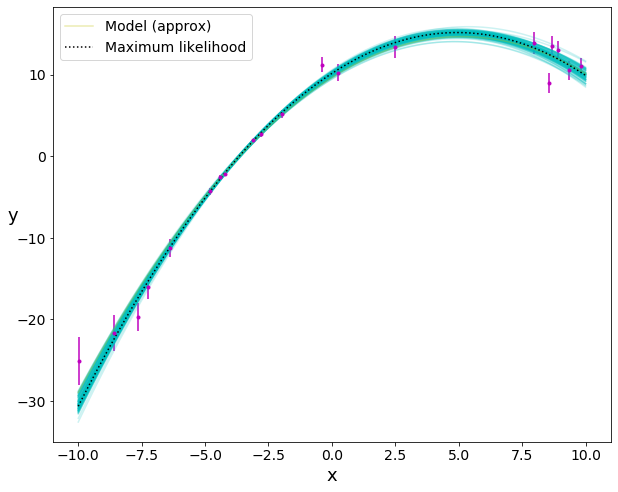

In [11]:
x1 = np.linspace(-10,10, 100)

a_list = []
b_list = []
c_list = []
lnf_list = []

for a, b, c, lnf in samples[np.random.randint(len(samples), size=100)]:
    a_list.append(a)
    b_list.append(b)
    c_list.append(c)
    lnf_list.append(lnf)

plt.figure(figsize=(10,8))
for i in range(100): 
    plt.plot(x1, a_list[i]*x1**2 + b_list[i]*x1 + c_list[i], color="c", alpha=0.2)
    #plt.draw()
plt.errorbar(x,y,yerr=yerr, fmt=".m",ecolor='m',capsize=0)
plt.plot(x0, a_approx*x0**2 + b_approx * x0 + c_approx, "y", alpha=0.3, label="Model (approx)")
plt.plot(x0, a_ml*x0**2 + b_ml * x0 + c_ml, ":k", label="Maximum likelihood")
plt.legend(fontsize=14)
plt.xlabel("x", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()